<b> <font size="4"> Data-608 Knowledge and Visual Analytics - Lecture 4 Assignment  </font> </b>

<b> Background: </b> Enterococcus is a fecal indicating bacteria that lives in the intestines of humans and other warm-blooded animals. Enterococcus (“ Entero”) counts are useful as a water quality indicator due to their abundance in human sewage, correlation with many human pathogens and low abundance in sewage free environments. The United States Environmental Protection Agency (EPA) reports Entero counts as colonies (or cells) per 100 ml of water.

Riverkeeper has based its assessment of acceptable water quality on the 2012 Federal Recreational Water Quality Criteria from the US EPA. Unacceptable water is based on an illness rate of 32 per 1000 swimmers. The federal standard for unacceptable water quality is a single sample value of greater than 110 Enterococcus/100 mL, or five or more samples with a geometric mean (a weighted average) greater than 30 Enterococcus/100 mL.

The following are questions we are to answer: 

- Create lists & graphs of the best and worst places to swim in the dataset.

- The testing of water quality can be sporadic. Which sites have been tested most regularly? Which ones have long gaps between tests? Pick out 5-10 sites and visually compare how regularly their water quality is tested.

- Is there a relationship between the amount of rain and water quality? Show this relationship graphically. If you can, estimate the effect of rain on quality at different sites and create a visualization to compare them.

Lets get started !!!.

First we load the data and the libraries. 

In [187]:
from pandas import DataFrame, Series, to_datetime, read_csv
from bokeh.charts import TimeSeries, show, output_file
import pandas as pd
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt

%matplotlib inline




In [115]:
river_entero = read_csv('https://raw.githubusercontent.com/kishkp/Data-608---Knowledge-and-Visual-Analytics/master/lecture4/data/riverkeeper_data_2013.csv')

Now lets do some cleanup and add some columns for Month and Year. We will do the following specifically:

1. We need to convert the 'Date' field to a datetime object.
2. Add Month and Year columns explictly to the dataset.
3. There are some special characters (< and >) in the EnteroCount field. We will replace these characters with ''.
4. We then convert the EnteroCount field to numeric.



In [116]:
river_entero['Date'] = Series([to_datetime(d) for d in river_entero['Date']])
river_entero['Year'] = river_entero['Date'].dt.year
river_entero['Month'] = river_entero['Date'].dt.month
river_entero['EnteroCount'] = pd.to_numeric(river_entero['EnteroCount'].replace(to_replace='[<>]', value='', regex=True), errors='ignore')

Lets have a look at the data now.

In [117]:
river_entero.head(5)

,Site,Date,EnteroCount,FourDayRainTotal,SampleCount,Year,Month
0,Hudson above Mohawk River,2011-10-16,1733,1.5,35,2011,10
1,Hudson above Mohawk River,2013-10-21,4,0.2,35,2013,10
2,Hudson above Mohawk River,2013-09-21,20,0.0,35,2013,9
3,Hudson above Mohawk River,2013-08-19,6,0.0,35,2013,8
4,Hudson above Mohawk River,2013-07-21,31,0.0,35,2013,7


Ok, let's make some graphs.


- Create lists & graphs of the best and worst places to swim in the dataset.

The federal standard for unacceptable water quality is a single sample value of greater than 110 Enterococcus/100 mL, or five or more samples with a geometric mean (a weighted average) greater than 30 Enterococcus/100 mL. 

We will calculate an average EnteroCount by month / year for a site. For a given year / month, we will sort the dataset by the average EnteroCount. Any site that has an average of greater than 110 Enterococcus/100 mL is a worse site to swim. We will then use this summarized dataset to show the best and the worst places to swim in a given year / month .


In [144]:
def plotthis(year, month, type):
    df = river_entero.ix[(river_entero['Year'] == int(year)) & (river_entero['Month'] == int(month)), ['Site', 'EnteroCount']]
    df_slice = df.groupby('Site', as_index=False)['EnteroCount'].mean()

    if(type=='Best'):
        df_new = df_slice.ix[(df_slice['EnteroCount'] < 110), ['Site', 'EnteroCount']]
        df_new.sort_values(ascending=True, by='EnteroCount', inplace=True, axis=0)
    else:
        df_new = df_slice.ix[(df_slice['EnteroCount'] >= 110), ['Site', 'EnteroCount']]
        df_new.sort_values(ascending=False, by='EnteroCount', inplace=True, axis=0)

    
    df_new.set_index(["Site"],inplace=True)
    df_new.plot(kind='bar')

<function __main__.plotthis>

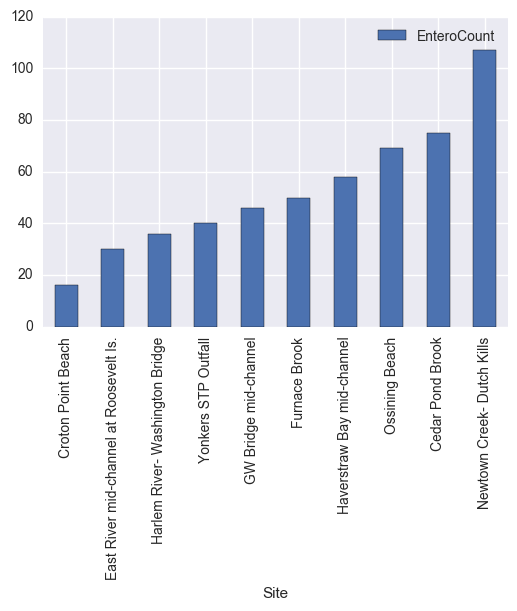

In [145]:
Year = widgets.Dropdown(
    options=list(river_entero['Year'].unique()),
    value=2006,
    description='Year:',
    disabled=False,
    button_style='')

Month = widgets.Dropdown(
    options=list(river_entero['Month'].unique()),
    value=12,
    description='Month:',
    disabled=False,
    button_style='')

Type = widgets.ToggleButtons(
    options=['Best', 'Worst'],
    description='Type:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#    tooltip='Description',
#     icon='check'
)

widgets.interact(plotthis, year=Year, month=Month, type=Type)


- The testing of water quality can be sporadic. Which sites have been tested most regularly? 
    Which ones have long gaps between tests? Pick out 5-10 sites and visually compare how regularly their water quality is tested.
    
To see this visualization, we will calculate a frequency / count for the number of times each site is tested by month/year. we will then show this in a plot with a multi-select widget. 

In [201]:
def plotthis_1(sites):
    #sites = ['125th St. Pier']
    df = river_entero[river_entero['Site'].isin(sites)]
    df = pd.DataFrame(df.groupby(['Year', 'Month', 'Site']).size().reset_index(name='counts'))

    df['Period'] = df.Year.astype(str).str.cat(df.Month.astype(str), sep='-')
    dslice = df.pivot(index = 'Period', columns = 'Site', values = 'counts')
    plt.figure() 
    dslice.plot()


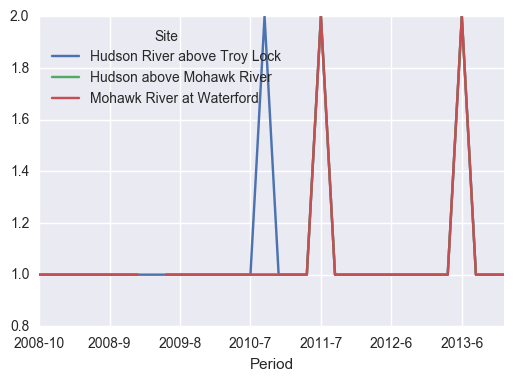

In [202]:
Sites = widgets.SelectMultiple(
    options=list(river_entero['Site'].unique()),
    value=['125th St. Pier'],
    description='Sites',
    disabled=False
)

widgets.interact(plotthis_1, sites=Sites)



- Is there a relationship between the amount of rain and water quality? Show this relationship graphically. If you can, estimate the effect of rain on quality at different sites and create a visualization to compare them.

We will use a simple scatter plot to show the relationship between rain and quality. As before, we will use a multi-select to show the comparison between different sites.


In [250]:
import seaborn as sns; sns.set(color_codes=True)

def plotthis_2(sites):
    #sites = ['125th St. Pier', '79th St. mid-channel']
    df = river_entero[river_entero['Site'].isin(sites)]
    df['Period'] = df.Year.astype(str).str.cat(df.Month.astype(str), sep='-')
    df = df.ix[ :, ['Period', 'Site', 'EnteroCount', 'FourDayRainTotal']]
    df_new = pd.DataFrame(df.groupby(['Period', 'Site'], as_index=False).mean())

    g = sns.lmplot(x="EnteroCount", y="FourDayRainTotal", hue="Site", data=df_new)

C:\Users\GBM\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



<function __main__.plotthis_2>

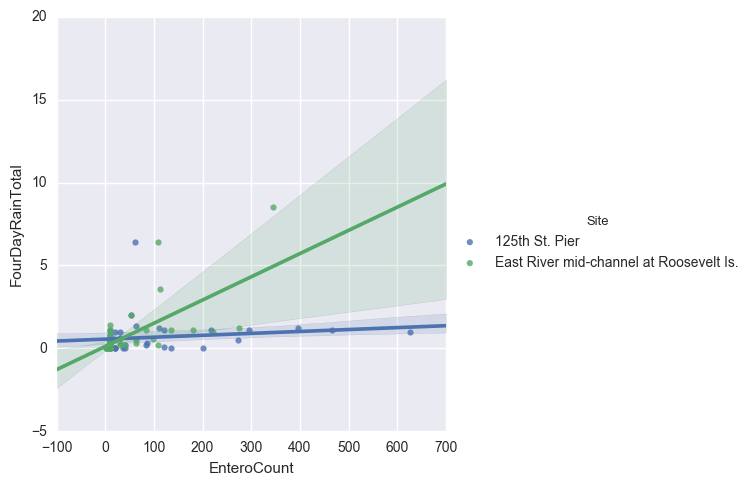

In [251]:
Sites = widgets.SelectMultiple(
    options=list(river_entero['Site'].unique()),
    value=['125th St. Pier', 'East River mid-channel at Roosevelt Is.'],
    description='Sites',
    disabled=False
)

widgets.interact(plotthis_2, sites=Sites)
